# 순환 신경망(Recurrent Neural Network, RNN)

- 루프(loop)를 가진 신경망의 한 종류

- 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태(state)에 저장

<img src="https://miro.medium.com/max/627/1*go8PHsPNbbV6qRiwpUQ5BQ.png">

<sub>출처: https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e</sub>

## 순환 신경망 레이어 (RNN Layer)

- 입력: `(timesteps, input_features)`

- 출력: `(timesteps, output_features)`

In [3]:
import numpy as np

In [4]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features, ))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))

successive_output = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_output.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_output, axis=0)  

## 케라스의 순환층
- `SimpleRNN` layer

- 입력: `(batch_size, timesteps, input_features)`

- 출력
  - `return_sequences`로 결정할 수 있음
  
  - 3D 텐서
    - 타임스텝의 출력을 모은 전체 시퀀스를 반환

    - `(batch_size, timesteps, output_features)`

  - 2D 텐서
    - 입력 시퀀스에 대한 마지막 출력만 반환

    - `(batch_size, output_features)`


In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import SimpleRNN, Embedding
from keras.models import Sequential

In [7]:
model = Sequential()

model.add(Embedding(10_000, 32))
model.add(SimpleRNN(32, return_sequences=True))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 네트워크의 표현력을 증가시키기 위해 여러 개의 순환층을 차례대로 쌓는 것이 유용할 때가 있음

  - 이런 설정에서는 중간층들이 전체 출력 시퀀스를 반환하도록 설정

In [8]:
model = Sequential()

model.add(Embedding(10_000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328320 (1.25 MB)
Trainable params: 328320 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## IMDB 데이터 적용

### 데이터 로드

In [9]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [10]:
num_words = 10_000
max_len = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)

print(len(input_train))
print(len(input_test))

input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)

print(input_train.shape)
print(input_test.shape)

25000
25000
(25000, 500)
(25000, 500)


### 모델 구성

In [11]:
from keras.layers import Dense

In [12]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습

In [13]:
hist = model.fit(
    input_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=.2
)

Epoch 1/10


2024-01-17 16:53:17.955598: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f26cc1e9fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 16:53:17.955697: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-01-17 16:53:17.971905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-17 16:53:18.005884: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1705477998.067720   24784 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - 173s 1s/step - loss: 0.6528 - accuracy: 0.5982 - val_loss: 0.4678 - val_accuracy: 0.7998
Epoch 2/10
157/157 [==============================] - 164s 1s/step - loss: 0.4264 - accuracy: 0.8147 - val_loss: 0.6693 - val_accuracy: 0.6922
Epoch 3/10
157/157 [==============================] - 174s 1s/step - loss: 0.3166 - accuracy: 0.8738 - val_loss: 0.4724 - val_accuracy: 0.7762
Epoch 4/10
157/157 [==============================] - 168s 1s/step - loss: 0.2476 - accuracy: 0.9031 - val_loss: 0.4555 - val_accuracy: 0.7894
Epoch 5/10
157/157 [==============================] - 150s 953ms/step - loss: 0.1920 - accuracy: 0.9280 - val_loss: 0.3872 - val_accuracy: 0.8452
Epoch 6/10
157/157 [==============================] - 165s 1s/step - loss: 0.1273 - accuracy: 0.9561 - val_loss: 0.4418 - val_accuracy: 0.8244
Epoch 7/10
157/157 [==============================] - 161s 1s/step - loss: 0.0868 - accuracy: 0.9725 - val_loss: 0.4643 - val_accuracy: 0.8216
Epoch 8

### 시각화

In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

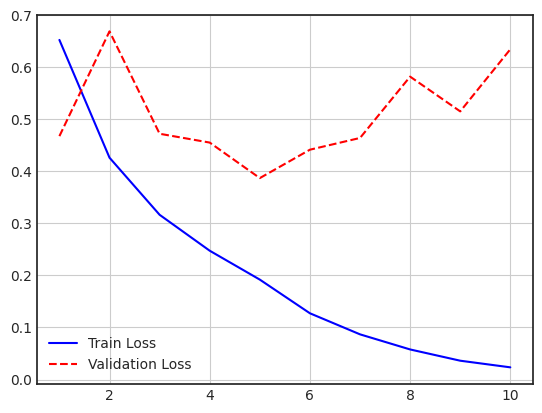

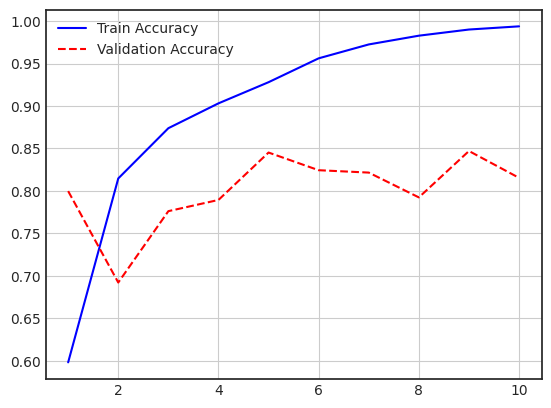

In [15]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

In [16]:
model.evaluate(input_test, y_test )

782/782 [==============================] - 56s 71ms/step - loss: 0.6493 - accuracy: 0.8174


[0.6493090987205505, 0.8173999786376953]

- 전체 시퀀스가 아니라 순서대로 500개의 단어만 입력했기 때문에 성능이 낮게 나옴

- SimpleRNN은 긴 시퀀스를 처리하는데 적합하지 않음

# LSTM과 GRU 레이어

- SimpleRNN은 실전에 사용하기엔 너무 단순

- SimpleRNN은 이론적으로 시간 $t$ 에서 이전의 모든 타임스텝의 정보를 유지할 수 있지만, 실제로는 긴 시간에 걸친 의존성은 학습할 수 없음

- 그래디언트 소실 문제(vanishing gradient problem)
  - 이를 방지하기 위해 LSTM, GRU 같은 레이어 등장



## LSTM(Long Short-Term Memory)
- 장단기 메모리 알고리즘

- 나중을 위해 정보를 저장함으로써 오래된 시그널이 점차 소실되는 것을 막아줌

  <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png">

  <sub>출처: https://colah.github.io/posts/2015-08-Understanding-LSTMs/</sub>

## 예제로 보는 순환 신경망: Reuters

- IMDB와 유사한 데이터셋(텍스트 데이터)

- 46개의 상호 배타적인 토픽으로 이루어진 데이터셋
  - 다중 분류 문제


### 데이터셋 로드

In [17]:
from keras.datasets import reuters

In [18]:
num_words = 10_000

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

2110848/2110848 [==============================] - 1s 0us/step
(8982,)
(8982,)
(2246,)
(2246,)


### 데이터 전처리 및 확인

In [19]:
from keras.preprocessing.sequence import pad_sequences

In [20]:
max_len = 500

In [22]:
pad_x_train = pad_sequences(x_train, maxlen=max_len)
pad_x_test = pad_sequences(x_test, maxlen=max_len)

print(len(pad_x_train[0]))

500


In [23]:
pad_x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### 모델 구성
- LSTM 레이어도 SimpleRNN과 같이 `return_sequences` 인자 사용가능

In [24]:
from keras.layers import LSTM, Dense, Embedding

In [25]:
model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=64))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(46, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 46)                1518      
                                                                 
Total params: 686958 (2.62 MB)
Trainable params: 686958 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습

In [26]:
hist = model.fit(
    pad_x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=.2
)

Epoch 1/20
225/225 [==============================] - 33s 139ms/step - loss: 2.5417 - accuracy: 0.3511 - val_loss: 2.4103 - val_accuracy: 0.3450
Epoch 2/20
225/225 [==============================] - 25s 110ms/step - loss: 2.3683 - accuracy: 0.3756 - val_loss: 2.0930 - val_accuracy: 0.5025
Epoch 3/20
225/225 [==============================] - 23s 102ms/step - loss: 2.0007 - accuracy: 0.5066 - val_loss: 1.8884 - val_accuracy: 0.4836
Epoch 4/20
225/225 [==============================] - 19s 85ms/step - loss: 1.8192 - accuracy: 0.5170 - val_loss: 1.7322 - val_accuracy: 0.5437
Epoch 5/20
225/225 [==============================] - 18s 81ms/step - loss: 1.6931 - accuracy: 0.5633 - val_loss: 1.6639 - val_accuracy: 0.5565
Epoch 6/20
225/225 [==============================] - 18s 78ms/step - loss: 1.6038 - accuracy: 0.5763 - val_loss: 1.6842 - val_accuracy: 0.5626
Epoch 7/20
225/225 [==============================] - 16s 71ms/step - loss: 1.5088 - accuracy: 0.6090 - val_loss: 1.6168 - val_accura

### 시각화

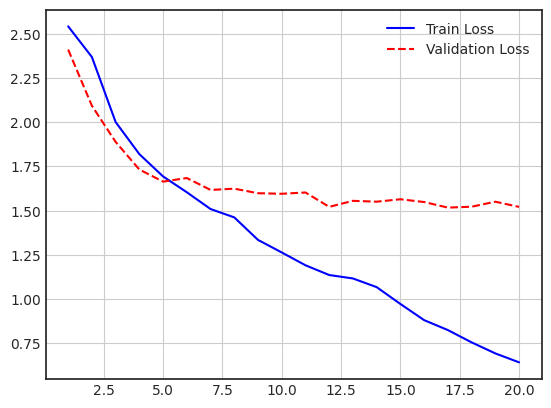

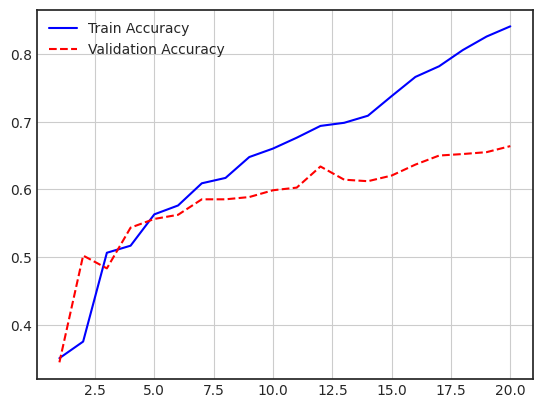

In [27]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

### 모델 평가


In [28]:
model.evaluate(pad_x_test, y_test)

71/71 [==============================] - 2s 28ms/step - loss: 1.6272 - accuracy: 0.6545


[1.6271755695343018, 0.6544969081878662]

## IMDB 데이터셋 with LSTM

### 데이터 로드

In [29]:
num_words = 10_000
max_len = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)

print(len(input_train))
print(len(input_test))

input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)

print(input_train.shape)
print(input_test.shape)

25000
25000
(25000, 500)
(25000, 500)


### 모델 구성

In [32]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습

In [33]:
hist = model.fit(
    input_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=.2
)

Epoch 1/10
157/157 [==============================] - 12s 70ms/step - loss: 0.6073 - accuracy: 0.6611 - val_loss: 0.4599 - val_accuracy: 0.8040
Epoch 2/10
157/157 [==============================] - 9s 57ms/step - loss: 0.3651 - accuracy: 0.8525 - val_loss: 0.3882 - val_accuracy: 0.8426
Epoch 3/10
157/157 [==============================] - 8s 52ms/step - loss: 0.2764 - accuracy: 0.8928 - val_loss: 0.4039 - val_accuracy: 0.8364
Epoch 4/10
157/157 [==============================] - 7s 46ms/step - loss: 0.2344 - accuracy: 0.9108 - val_loss: 0.3257 - val_accuracy: 0.8648
Epoch 5/10
157/157 [==============================] - 7s 45ms/step - loss: 0.2055 - accuracy: 0.9228 - val_loss: 0.3138 - val_accuracy: 0.8686
Epoch 6/10
157/157 [==============================] - 7s 44ms/step - loss: 0.1849 - accuracy: 0.9327 - val_loss: 0.4118 - val_accuracy: 0.8452
Epoch 7/10
157/157 [==============================] - 6s 40ms/step - loss: 0.1644 - accuracy: 0.9434 - val_loss: 0.3145 - val_accuracy: 0.883

### 시각화

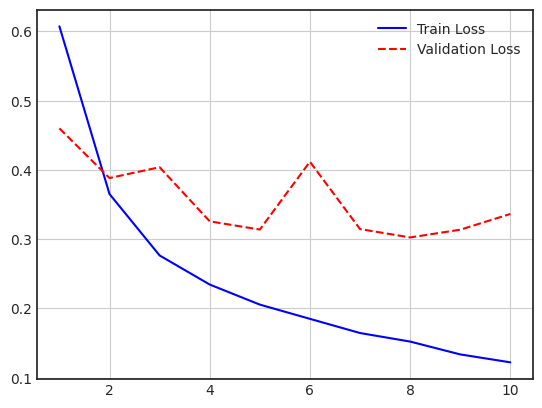

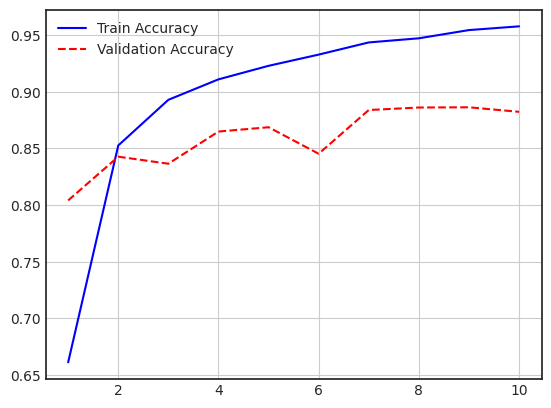

In [34]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

### 모델 평가

In [36]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 14s 17ms/step - loss: 0.3793 - accuracy: 0.8677


[0.37925535440444946, 0.867680013179779]

# Cosine 함수를 이용한 순환 신경망

In [37]:
import numpy as np

In [67]:
np.random.seed(42)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5, np.cos(2 * np.cos(np.pi * month_time)), np.cos(2 * np.cos(np.pi * month_time) + np.random.random(361)))

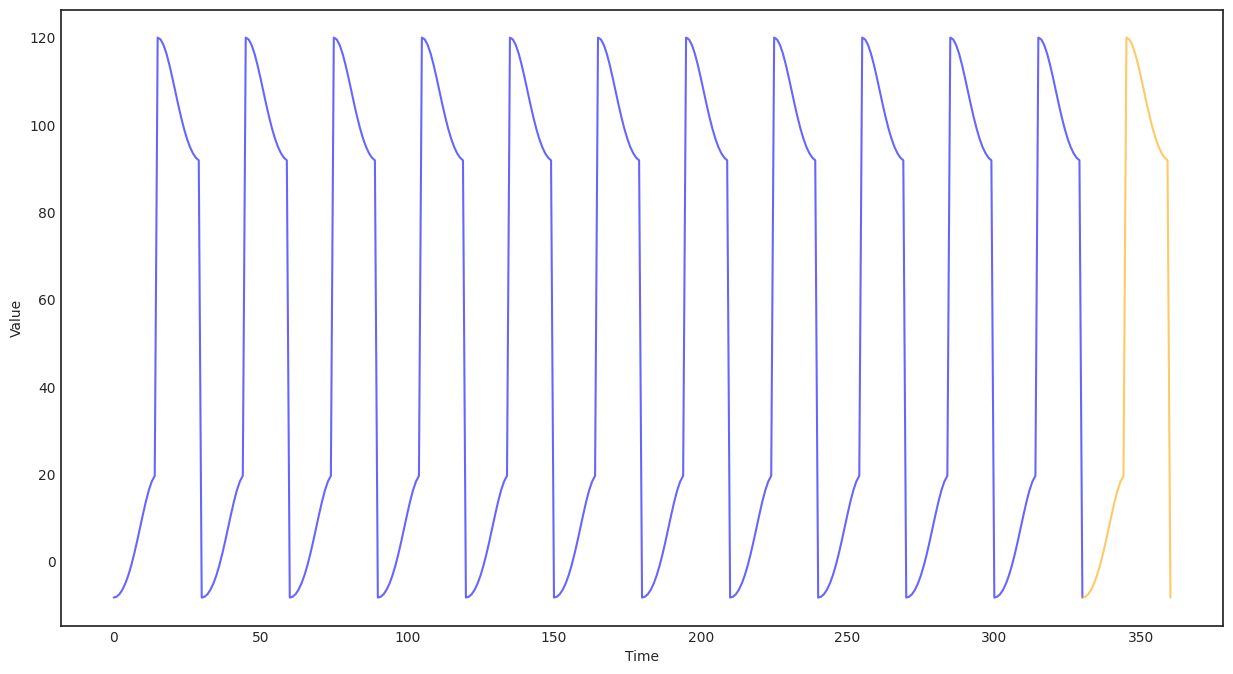

In [68]:
plt.figure(figsize=(15, 8))

plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color='blue', alpha=.6, label='Train Data')
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color='orange', alpha=.6, label='Test Data')

plt.show()

In [42]:
def make_data(time_series, n):
    x_train_full, y_train_full = list(), list()

    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        
        if i + n < len(time_series):
            x_train_full.append(x)
            y_train_full.append(time_series[i + n])
        else:
            break
    
    x_train_full, y_train_full = np.array(x_train_full), np.array(y_train_full)

    return x_train_full, y_train_full

In [43]:
n = 10
x_train_full, y_train_full = make_data(time_series, 10)

In [44]:
print(x_train_full.shape)
print(y_train_full.shape)

(351, 10)
(351,)


In [46]:
x_train_full = x_train_full.reshape(-1, n, 1)
y_train_full = y_train_full.reshape(-1, 1)

In [47]:
print(x_train_full.shape)
print(y_train_full.shape)

(351, 10, 1)
(351, 1)


## 테스트 데이터셋 생성

In [81]:
x_train = x_train_full[:30*11]
y_train = y_train_full[:30*11]
x_test = x_train_full[30*11:]
y_test = y_train_full[30*11:]

In [82]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(330, 10, 1)
(330, 1)
(21, 10, 1)
(21, 1)


## 데이터 확인

In [83]:
sample_series = np.arange(100)
a, b = make_data(sample_series, 10)

print(a[0])
print(b[0])

[0 1 2 3 4 5 6 7 8 9]
10


## 모델 구성

In [84]:
from keras.layers import SimpleRNN, Flatten, Dense

In [87]:
def build_model(n):
    model = Sequential()

    model.add(SimpleRNN(units=32, activation='tanh', input_shape=(n, 1)))
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
    )

    return model

In [88]:
model = build_model(10)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 모델 학습

In [90]:
model.fit(x_train, y_train, epochs=100, batch_size=16)

Epoch 1/100


21/21 [==============================] - 1s 11ms/step - loss: 163.1165
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 134.6928
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 115.2154
Epoch 4/100
21/21 [==============================] - 0s 13ms/step - loss: 99.9906
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 87.5199
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 78.0582
Epoch 7/100
21/21 [==============================] - 0s 13ms/step - loss: 71.0614
Epoch 8/100
21/21 [==============================] - 0s 13ms/step - loss: 64.0734
Epoch 9/100
21/21 [==============================] - 0s 14ms/step - loss: 55.9807
Epoch 10/100
21/21 [==============================] - 0s 13ms/step - loss: 51.4864
Epoch 11/100
21/21 [==============================] - 0s 13ms/step - loss: 47.8087
Epoch 12/100
21/21 [==============================] - 0s 12ms/step - loss: 44.5385
Epoch 13/100
21/21 [==

## 예측값 그려보기

1/1 [==============================] - 0s 13ms/step


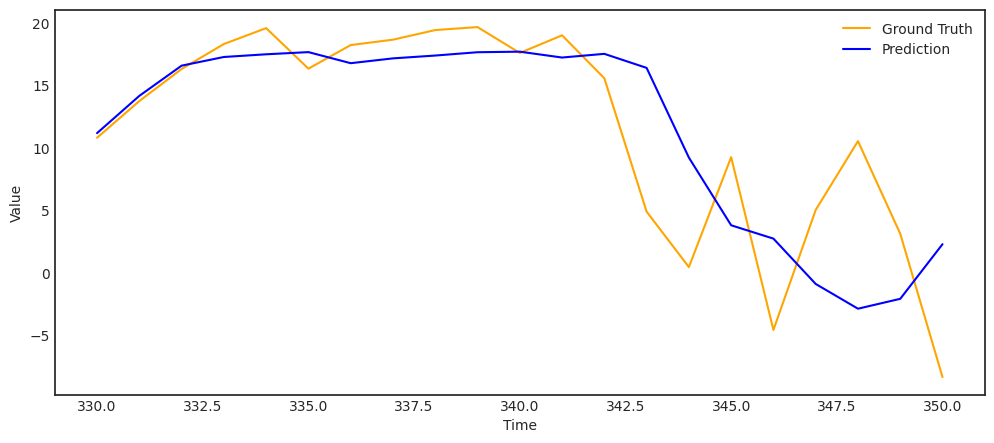

In [105]:
y_pred = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(12, 5))
plt.xlabel('Time')
plt.ylabel('Value')

plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, y_pred.flatten(), color='blue', label='Prediction')

plt.legend()

plt.show()

## 모델 재구성 (2)
- LSTM 사용

In [97]:
from keras.layers import LSTM

In [106]:
def build_model_2(n):
    model = Sequential()

    model.add(LSTM(units=64, input_shape=(n, 1), return_sequences=True))
    model.add(LSTM(units=32))
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
    )

    return model

In [107]:
model_2 = build_model_2(10)

model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 64)            16896     
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 모델 재학습 및 예측값 그려보기

In [108]:
model_2.fit(
    x_train, y_train,
    epochs=100,
    batch_size=16
)

Epoch 1/100


21/21 [==============================] - 2s 9ms/step - loss: 120.6634
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 83.0126
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 54.5579
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 44.0602
Epoch 5/100
21/21 [==============================] - 0s 8ms/step - loss: 37.9822
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 33.6522
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 29.0671
Epoch 8/100
21/21 [==============================] - 0s 6ms/step - loss: 26.1320
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 23.3327
Epoch 10/100
21/21 [==============================] - 0s 6ms/step - loss: 21.4085
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 19.7485
Epoch 12/100
21/21 [==============================] - 0s 6ms/step - loss: 18.9879
Epoch 13/100
21/21 [================

1/1 [==============================] - 0s 22ms/step


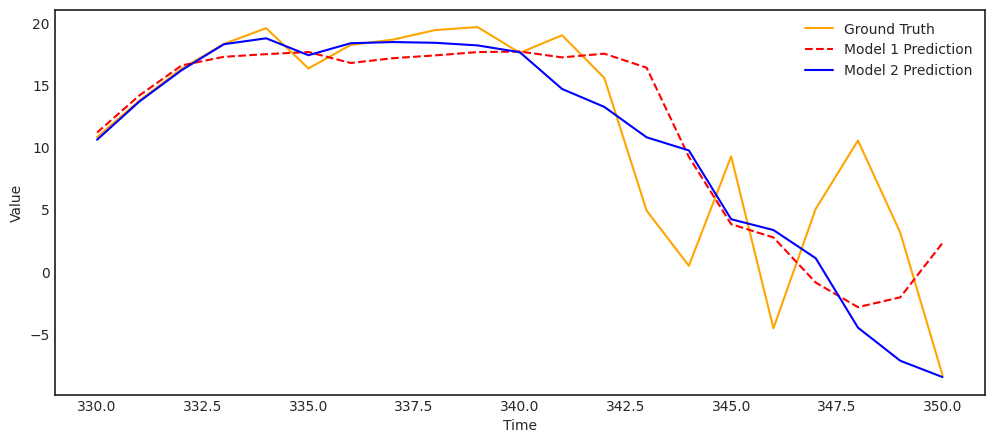

In [111]:
y_pred_2 = model_2.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(y_pred_2))

plt.figure(figsize=(12, 5))
plt.xlabel('Time')
plt.ylabel('Value')

plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, y_pred.flatten(), 'r--', label='Model 1 Prediction')
plt.plot(pred_range, y_pred_2.flatten(), color='blue', label='Model 2 Prediction')

plt.legend()

plt.show()

## 모델 재구성(3)
- GRU 사용
  - LSTM 보다 더 쉬운 구조

In [112]:
from keras.layers import GRU

In [113]:
def build_model_3(n):
    model = Sequential()

    model.add(GRU(units=32, input_shape=(n, 1), return_sequences=True))
    model.add(GRU(units=32))
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
    )

    return model

model_3 = build_model_3(10)

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 모델 재학습 및 예측값 그려보기

In [114]:
model_3.fit(
    x_train, y_train,
    epochs=100,
    batch_size=16
)

Epoch 1/100
21/21 [==============================] - 2s 14ms/step - loss: 132.1396
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 93.0663
Epoch 3/100
21/21 [==============================] - 0s 8ms/step - loss: 66.6566
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 51.8642
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 43.3542
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 37.6944
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 33.9197
Epoch 8/100
21/21 [==============================] - 0s 6ms/step - loss: 31.0807
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 28.4518
Epoch 10/100
21/21 [==============================] - 0s 6ms/step - loss: 26.3563
Epoch 11/100
21/21 [==============================] - 0s 6ms/step - loss: 24.4300
Epoch 12/100
21/21 [==============================] - 0s 6ms/step - loss: 22.3621
Epoch 13/100
21/21 [===

1/1 [==============================] - 0s 307ms/step


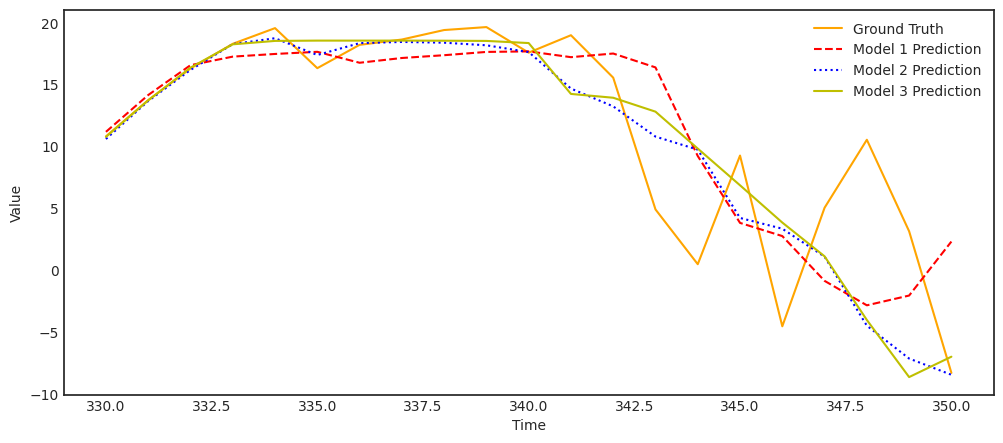

In [115]:
y_pred_3 = model_3.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(y_pred_3))

plt.figure(figsize=(12, 5))
plt.xlabel('Time')
plt.ylabel('Value')

plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, y_pred.flatten(), 'r--', label='Model 1 Prediction')
plt.plot(pred_range, y_pred_2.flatten(), 'b:', label='Model 2 Prediction')
plt.plot(pred_range, y_pred_3.flatten(), 'y-', label='Model 3 Prediction')

plt.legend()

plt.show()

# Conv1D

- 텍스트 분류나 시계열 예측 같은 간단한 문제, 오디오 생성, 기계 번역 등의 문제에서 좋은 성능

- 타임스텝의 순서에 민감하지 X


- 2D Convolution
  - 지역적 특징을 인식

  <img src="https://missinglink.ai/wp-content/uploads/2019/03/2D-convolutional-example_2x-700x584.png" width="500">

- 1D Convolution
  - 문맥을 인식

  <img src="https://missinglink.ai/wp-content/uploads/2019/03/1D-convolutional-example_2x.png" width="500">

  <sub>출처: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/</sub>

## Conv1D Layer
- 입력: `(batch_size, timesteps, channels)`

- 출력: `(batch_size, timesteps, filters)`

- 필터의 사이즈가 커져도 모델이 급격히 증가하지 않기 때문에 다양한 크기를 사용할 수 있음
- 데이터의 품질이 좋으면 굳이 크기를 달리하여 여러 개를 사용하지 않아도 될 수도 있음

## MaxPooling1D Layer
- 다운 샘플링 효과

- 단지 1차원형태로 바뀐 것 뿐

## GlovalMaxPooling Layer
- 배치차원을 제외하고 2차원 형태를 1차원 형태로 바꾸어주는 레이어

- Flatten layer로 대신 사용가능

## IMDB 데이터셋

### 데이터 로드 및 전처리

In [116]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [117]:
num_words = 10_000
max_len = 500
batch_size = 32

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

print(len(x_train))
print(len(x_test))

25000
25000


In [118]:
pad_x_train = pad_sequences(x_train, maxlen=max_len)
pad_x_test = pad_sequences(x_test, maxlen=max_len)

print(pad_x_train.shape)
print(pad_x_test.shape)

(25000, 500)
(25000, 500)


### 모델 구성

In [119]:
def build_model():
    model = Sequential()

    model.add(Embedding(input_dim=num_words, output_dim=32))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(MaxPooling1D(7))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=RMSprop(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [120]:
model = build_model()

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 conv1d (Conv1D)             (None, None, 32)          7200      
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                                 
 global_max_pooling1d (Glob  (None, 32)              

### 모델 학습

In [121]:
hist = model.fit(
    pad_x_train, y_train,
    epochs=30,
    batch_size=128,
    validation_split=.2
)

Epoch 1/30


2024-01-18 10:14:51.450064: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


157/157 [==============================] - 10s 49ms/step - loss: 0.6930 - accuracy: 0.5066 - val_loss: 0.6927 - val_accuracy: 0.5264
Epoch 2/30
157/157 [==============================] - 5s 33ms/step - loss: 0.6918 - accuracy: 0.5530 - val_loss: 0.6919 - val_accuracy: 0.5556
Epoch 3/30
157/157 [==============================] - 4s 27ms/step - loss: 0.6904 - accuracy: 0.5979 - val_loss: 0.6906 - val_accuracy: 0.5860
Epoch 4/30
157/157 [==============================] - 4s 26ms/step - loss: 0.6882 - accuracy: 0.6347 - val_loss: 0.6880 - val_accuracy: 0.6288
Epoch 5/30
157/157 [==============================] - 3s 20ms/step - loss: 0.6839 - accuracy: 0.6683 - val_loss: 0.6820 - val_accuracy: 0.6702
Epoch 6/30
157/157 [==============================] - 3s 19ms/step - loss: 0.6749 - accuracy: 0.6967 - val_loss: 0.6690 - val_accuracy: 0.6902
Epoch 7/30
157/157 [==============================] - 2s 14ms/step - loss: 0.6554 - accuracy: 0.7187 - val_loss: 0.6417 - val_accuracy: 0.7290
Epoch 8/3

### 시각화

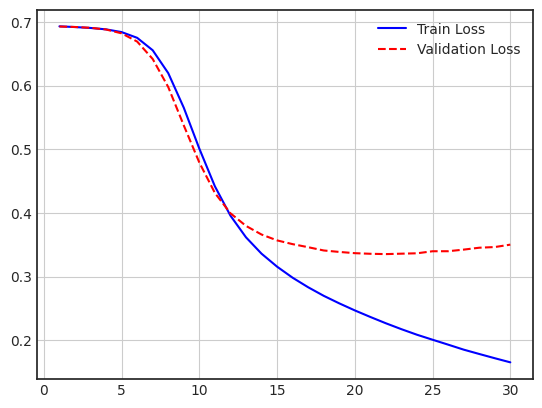

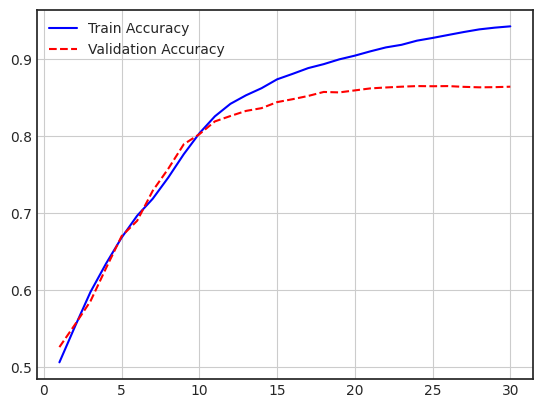

In [122]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

- 과적합이 일어났지만, 다른 옵티마이저 사용, 규제화를 걸어보는 등 다양하게 시도해볼 수 있음